### Basic Multi-agent Collaboration

A single agent can usually operate effectively using a handful of tools within a single domain, 
but even using powerful models like gpt-4, it can be less effective at using many tools.
This is the reason we need multiple agents - each specialised in a particular task.

### Divide-And-Conquer design pattern:

One way to approach complicated tasks is through a "divide-and-conquer" approach: 
create an specialized agent for each task or domain and route tasks to the correct "expert".

White Paper: https://arxiv.org/pdf/2308.08155


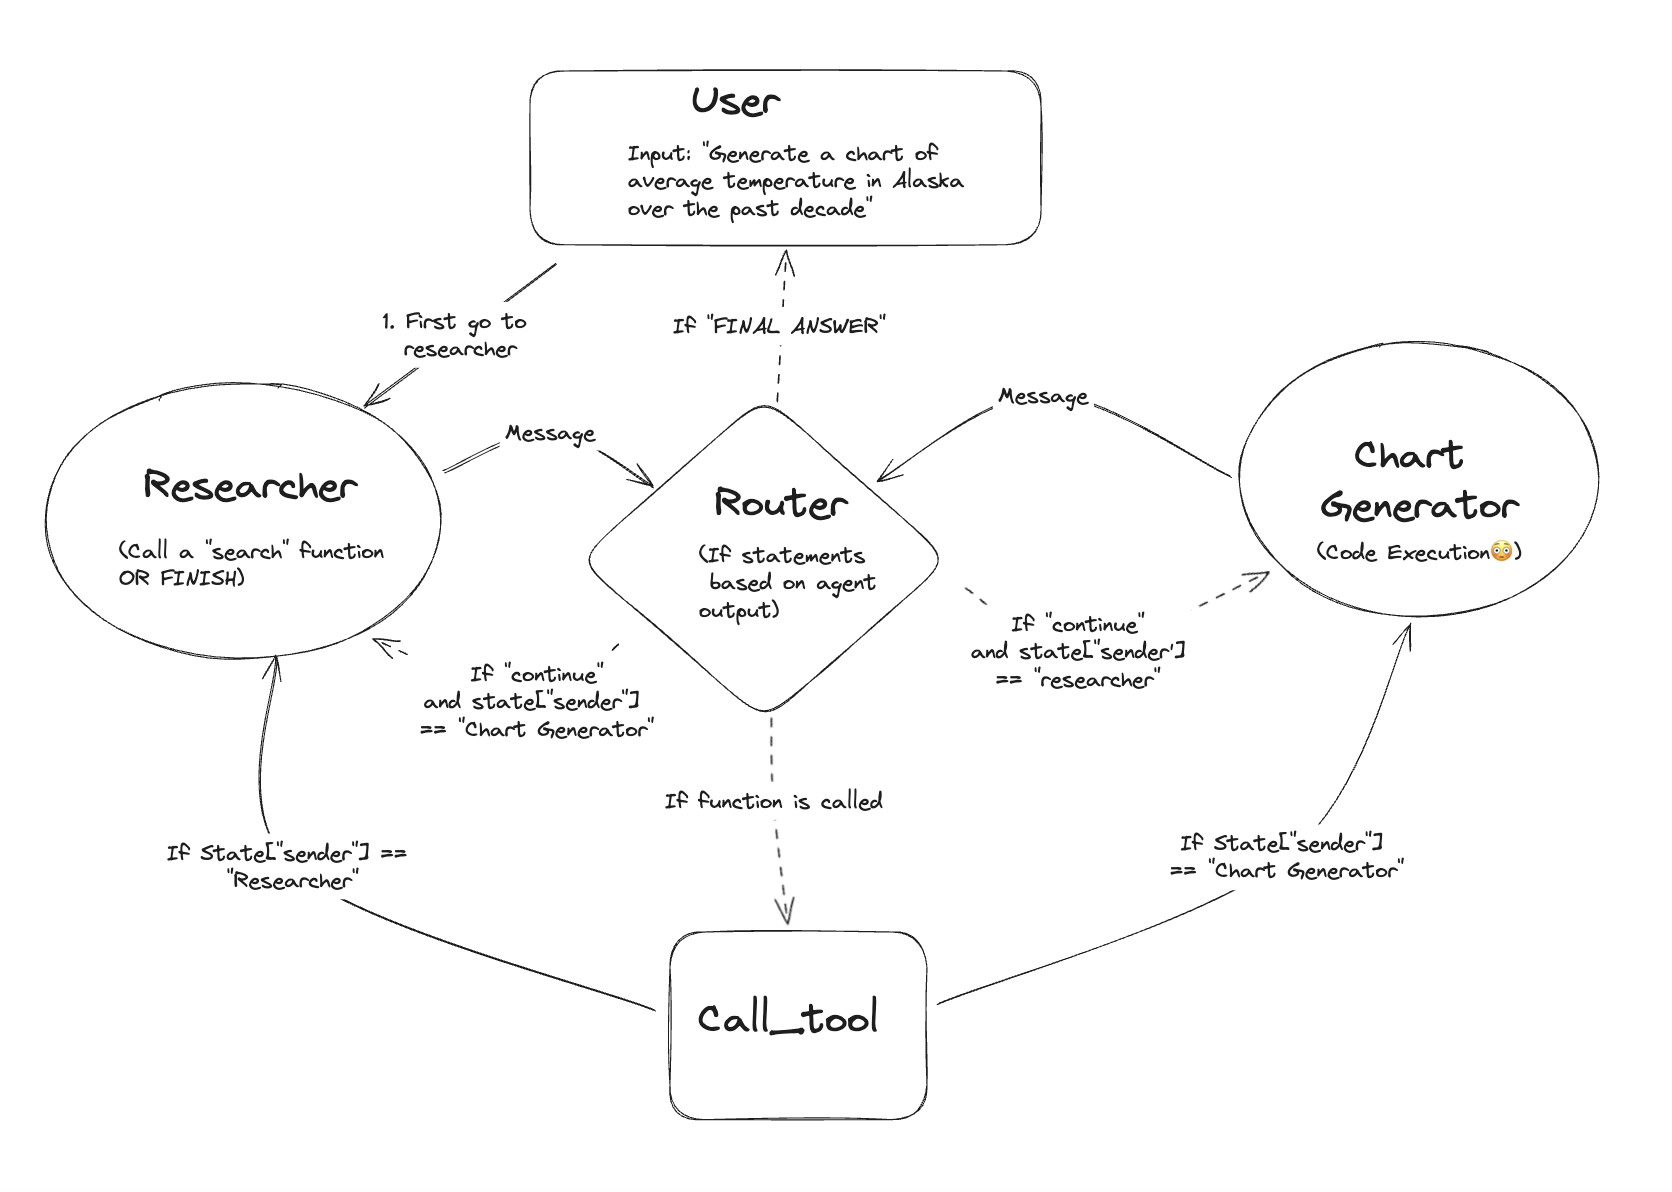


In [1]:
import os
from dotenv import load_dotenv
load_dotenv()

os.environ["LANGCHAIN_API_KEY"]=os.environ.get('LANGCHAIN_API_KEY')
os.environ["LANGCHAIN_TRACING_V2"]="true"
os.environ["LANGCHAIN_PROJECT"]="multi-agent-collaboration"
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model="gpt-4o-mini")

## Create Agents


The following helper functions will help create agents. 

These agents will then be nodes in the graph.


In [2]:
from langchain_core.messages import (
    BaseMessage,
    HumanMessage,
    ToolMessage,
)
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder

from langgraph.graph import END, StateGraph


def create_agent(llm, tools, system_message: str):
    """Create an agent."""
    prompt = ChatPromptTemplate.from_messages(
        [
            (
                "system",
                "You are a helpful AI assistant, collaborating with other assistants."
                " Use the provided tools to progress towards answering the question."
                " If you are unable to fully answer, that's OK, another assistant with different tools "
                " will help where you left off. Execute what you can to make progress."
                " If you or any of the other assistants have the final answer or deliverable,"
                " prefix your response with FINAL ANSWER so the team knows to stop."
                " You have access to the following tools: {tool_names}.\n{system_message}",
            ),
            MessagesPlaceholder(variable_name="messages"),
        ]
    )
    prompt = prompt.partial(system_message=system_message)
    prompt = prompt.partial(tool_names=", ".join([tool.name for tool in tools]))
    return prompt | llm.bind_tools(tools)

## Define tools


Define some tools that our agents will use in the future



In [3]:
from typing import Annotated

from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.tools import tool
from langchain_experimental.utilities import PythonREPL

tavily_tool = TavilySearchResults(max_results=5)

# Warning: This executes code locally, which can be unsafe when not sandboxed

repl = PythonREPL()


@tool
def python_repl(
    code: Annotated[str, "The python code to execute to generate your chart."],
):
    """Use this to execute python code. If you want to see the output of a value,
    you should print it out with `print(...)`. This is visible to the user."""
    try:
        result = repl.run(code)
    except BaseException as e:
        return f"Failed to execute. Error: {repr(e)}"
    result_str = f"Successfully executed:\n```python\n{code}\n```\nStdout: {result}"
    return (
        result_str + "\n\nIf you have completed all tasks, respond with FINAL ANSWER."
    )

# Create the graph

Now that we've defined our tools and made some helper functions, 
will create the individual agents below and tell them how to talk to each other using LangGraph.

### So understand how it works:

1) You create tools
2) These tools will be used by the "agents"
3) The "agents" shall become "nodes" in the graph
4) The "graph" tells the agents how to "talk" to each other.


**For creating the graph - first we define the "State" which is basically the "object" that is passed between the various "nodes"  in the "graph".**



In [4]:
import operator
from typing import Annotated, Sequence, TypedDict

# This defines the object that is passed between each node
# in the graph. We will create different nodes for each agent and tool
class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], operator.add]
    sender: str

# Define Agent Nodes
We now need to define the nodes. 

First, let's define the nodes for the agents.

In [5]:
import functools

from langchain_core.messages import AIMessage

# Helper function to create a node for a given agent
def agent_node(state, agent, name):
    result = agent.invoke(state)
    # We convert the agent output into a format that is suitable to append to the global state
    if isinstance(result, ToolMessage):
        pass
    else:
        result = AIMessage(**result.dict(exclude={"type", "name"}), name=name)
    return {
        "messages": [result],
        # Since we have a strict workflow, we can
        # track the sender so we know who to pass to next.
        "sender": name,
    }



# Research agent and node
research_agent = create_agent(
    llm,
    [tavily_tool],
    system_message="You should provide accurate data for use, "
        "and source code shouldn't be the final answer",
)
research_node = functools.partial(agent_node, agent=research_agent, name="Researcher")

# chart_generator
chart_agent = create_agent(
    llm,
    [python_repl],
    system_message="Run the python code to display the chart.",
)
chart_node = functools.partial(agent_node, agent=chart_agent, name="chart_generator")


# Define Tool Node
We now define a node to run the tools

In [6]:
from langgraph.prebuilt import ToolNode

tools = [tavily_tool, python_repl]
tool_node = ToolNode(tools)


# Define Edge Logic
We can define some of the edge logic that is needed to decide what to do based on results of the agents

In [7]:
# Either agent can decide to end
import time
from typing import Literal


def router(state) -> Literal["call_tool", "__end__", "continue"]:
    # This is the router
    messages = state["messages"]
    last_message = messages[-1]
    if last_message.tool_calls:
        time.sleep(10)
        # The previous agent is invoking a tool
        return "call_tool"
    if "FINAL ANSWER" in last_message.content:
        # Any agent decided the work is done
        return "__end__"
    return "continue"


# Define the Graph
We can now put it all together and define the graph!

In [8]:
workflow = StateGraph(AgentState)

workflow.add_node("Researcher", research_node)
workflow.add_node("chart_generator", chart_node)
workflow.add_node("call_tool", tool_node)

workflow.add_conditional_edges(
    "Researcher",
    router,
    {"continue": "chart_generator", "call_tool": "call_tool", "__end__": END},
)
workflow.add_conditional_edges(
    "chart_generator",
    router,
    {"continue": "Researcher", "call_tool": "call_tool", "__end__": END},
)

workflow.add_conditional_edges(
    "call_tool",
    # Each agent node updates the 'sender' field
    # the tool calling node does not, meaning
    # this edge will route back to the original agent
    # who invoked the tool
    lambda x: x["sender"],
    {
        "Researcher": "Researcher",
        "chart_generator": "chart_generator",
    },
)
workflow.set_entry_point("Researcher")
graph = workflow.compile()

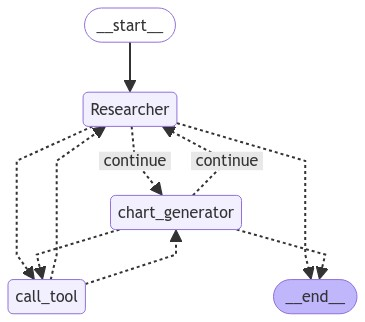

In [9]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph(xray=True).draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass


# Invoke
With the graph created, you can invoke it! Let's have it chart some stats for us.

{'Researcher': {'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_PmvubTe4xxatRGV6OSYAfojf', 'function': {'arguments': '{"query":"UK GDP historical data past 5 years"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 25, 'prompt_tokens': 240, 'total_tokens': 265}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_48196bc67a', 'finish_reason': 'tool_calls', 'logprobs': None}, name='Researcher', id='run-b642c9c5-f1d5-416d-8f1d-940543fa7e91-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'UK GDP historical data past 5 years'}, 'id': 'call_PmvubTe4xxatRGV6OSYAfojf', 'type': 'tool_call'}], usage_metadata={'input_tokens': 240, 'output_tokens': 25, 'total_tokens': 265})], 'sender': 'Researcher'}}
----
{'call_tool': {'messages': [ToolMessage(content='[{"url": "https://tradingeconomics.com/united-kingdom/gdp", "content": "The Gross Domestic Product (GDP

Python REPL can execute arbitrary code. Use with caution.


{'chart_generator': {'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_YXvgQXcgwmo2vh6GUT6XTV6Y', 'function': {'arguments': '{"code":"import matplotlib.pyplot as plt\\n\\n# Years and GDP values\\nyears = [2019, 2020, 2021, 2022, 2023]\\ngdp_values = [2851.41, 2697.81, 3141.51, 3194.82, 3340.03]\\n\\n# Create the plot\\nplt.figure(figsize=(10, 5))\\nplt.plot(years, gdp_values, marker=\'o\')\\n\\n# Adding title and labels\\nplt.title(\\"UK GDP Over the Past 5 Years\\")\\nplt.xlabel(\\"Year\\")\\nplt.ylabel(\\"GDP in Billion USD\\")\\nplt.xticks(years)  # Ensuring all years are marked on the x-axis\\nplt.grid()\\n\\n# Show the plot\\nplt.show()"}', 'name': 'python_repl'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 187, 'prompt_tokens': 2616, 'total_tokens': 2803}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_48196bc67a', 'finish_reason': 'tool_calls', 'logprobs': None}, name='chart_generator', id='run

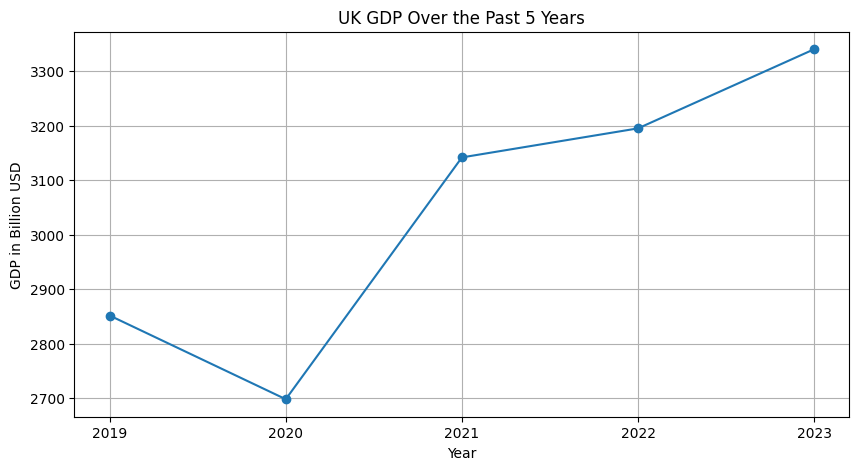

{'call_tool': {'messages': [ToolMessage(content='Successfully executed:\n```python\nimport matplotlib.pyplot as plt\n\n# Years and GDP values\nyears = [2019, 2020, 2021, 2022, 2023]\ngdp_values = [2851.41, 2697.81, 3141.51, 3194.82, 3340.03]\n\n# Create the plot\nplt.figure(figsize=(10, 5))\nplt.plot(years, gdp_values, marker=\'o\')\n\n# Adding title and labels\nplt.title("UK GDP Over the Past 5 Years")\nplt.xlabel("Year")\nplt.ylabel("GDP in Billion USD")\nplt.xticks(years)  # Ensuring all years are marked on the x-axis\nplt.grid()\n\n# Show the plot\nplt.show()\n```\nStdout: \n\nIf you have completed all tasks, respond with FINAL ANSWER.', name='python_repl', tool_call_id='call_YXvgQXcgwmo2vh6GUT6XTV6Y')]}}
----
{'chart_generator': {'messages': [AIMessage(content="FINAL ANSWER\n\nI have successfully plotted the UK's GDP over the past 5 years. The graph shows the GDP values for each year, clearly illustrating the changes over this period. If you need any further information or assista

In [12]:
events = graph.stream(
    {
        "messages": [
            HumanMessage(
                content="Fetch the UK's GDP over the past 5 years,"
                " then draw a line graph of it. DOn't just give me code to create the graph. You need to actually plot it"
                " Once you code it up, finish."
            )
        ],
    },
    # Maximum number of steps to take in the graph
    {"recursion_limit": 150},
)
for s in events:
    print(s)
    print("----")